# ocean_driven_SST:

SST anomalies caused by anomalous ocean circulation in the eastern equatorial Pacific.

Computes the amount of cooling (warming) by anomalous ocean circulation needed to generate surface temperature anomalies (SSTA) of -1 (1) °C during La Nina (El Nino) events in the eastern equatorial Pacific (horizontal Niño3 average)

#### Reference observations:
TropFlux 1979-2018 (main)

NHF: OAFlux-ISCCP 1984-2009, DEEP-C 1985-2016, ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023
SST: ERSSTv5 1854-2023, HadISST 1870-2023, COBE2 1850-2023, ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023


In [1]:
from esmvalcore.dataset import Dataset
from esmvalcore.config import CFG
CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2') #NCEP-DOE-R2 tos

In [2]:
# variables ts, hfds
model_ts_datasets = { 
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}
model_ts_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

model_ts = {name: dataset.load() for name, dataset in model_ts_datasets.items()}

In [3]:
model_hfls_datasets = { 
"ACCESS-ESM1-5": 
    Dataset(
    short_name='hfls',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

model_hfls_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacella', mip='fx')

#rest variables
model_other = {}
for cvar in ['hfss','rlds','rlus','rsds','rsus']:
    
    model_other[cvar] = model_hfls_datasets["ACCESS-ESM1-5"].copy(short_name=cvar)


In [4]:
model_hfls = {name: dataset.load() for name, dataset in model_hfls_datasets.items()}
model_rest = {name: dataset.load() for name, dataset in model_other.items()}

# nhf = -*hfls* -hfss + rlds - rlus + rsds - rsus #if 'd' make positive
model_nhf = - model_hfls['ACCESS-ESM1-5'] - model_rest['hfss'] + model_rest['rlds']- model_rest['rlus']+ model_rest['rsds']- model_rest['rsus']
#replace dict

 hfls: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/hfls/gn/v20191115/hfls_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc
 hfls: attribute positive not present
loaded from file 
 hfss: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/hfss/gn/v20191115/hfss_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc
 hfss: attribute positive not present
loaded from file 
 rlds: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/rlds/gn/v20191115/rlds_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc
 rlds: attribute positive not present
loaded from file 
 rlus: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/rlus/gn/v20191115/rlus_Amon_ACCESS-ESM

In [5]:
for cvar in ['hfss','rlds','rlus','rsds','rsus']:
    [c.summary() for c in model_rest[cvar].coords()]

In [12]:
obs_tos_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    timerange="19790101/20190101",
    tier=2),
"TROPFLUX":
    Dataset(
    short_name='tos',
    dataset='TROPFLUX',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    timerange="19790101/20190101",
    tier=2)
}
obs_nhf_datasets = { ##
 # "TROPFLUX": ##netflux data to kj13
 #     Dataset(
 #     short_name='hfds',
 #     dataset='TROPFLUX',
 #     mip="Omon",
 #     project='OBS6',
 #     type='reanaly',
 #     timerange="19790101/20190101",
     # tier=2),
 "ERA-Interim": 
     Dataset(
     short_name='hfds',
     dataset='ERA-Interim',
     mip="Omon",
     project='OBS6',
     type='reanaly',
     timerange="19790101/20190101",
     tier=3)
}

In [13]:
obs_nhf = {name: dataset.load() for name, dataset in obs_nhf_datasets.items()}
obs_tos = {name: dataset.load() for name, dataset in obs_tos_datasets.items()}

In [14]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import seasonal_statistics
from esmvalcore.preprocessor import annual_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
from esmvalcore.preprocessor import extract_time
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats

In [15]:
def sst_enso_n34(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = convert_units(cube, units="degC")
    # cube = mask_landsea(cube, mask_out="land") #
    cube = extract_region(cube, **nino34_latext_region)
    # #remove time mean
    cube = anomalies(cube, period='monthly') 
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)##rolling window cuts off months?
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = area_statistics(cube,operator='mean')
    cube = extract_month(cube,12)
    # detrend?
    cube = detrend(cube, dimension="time", method="linear")
    # normalize time series using its temporal standard deviation
    return cube
    
def east(cube):
    nino3_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    # cube = convert_units(cube, units="degC")
    cube = extract_region(cube, **nino3_region)
    cube = anomalies(cube, period="full") #remove seasonal cycle
    # cube = detrend(cube, dimension="time", method="linear")
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)##rolling window cuts off months?
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = area_statistics(cube, operator='mean')
    
    return cube

In [26]:
## dsst_nhf
#nhf : season, annual
def trend_month_sst(cube_prep): #e.g., dSST[feb] = SST[feb] - SST [jan]
    a_data = cube_prep.data.data
    a1_data = np.append(np.delete(a_data, 0), 0) #add 0 to end
    trend_data = a1_data - a_data #last month value invalid
    cube_prep.data = trend_data
    cube = extract_season(cube_prep,'JASOND')
    cube = annual_statistics(cube, 'sum')[:-1]
    return cube

def dSSTnhf(nhf_east, sst_east):
    dtime = 60 * 60 * 24 * 30.42 #s month-1
    Cp = 4000 #J kg-1 degC-1
    rho = 1024 #kg m-3
    H = 50 #m
    print(nhf_east.shape, sst_east.shape)
    # datetime_match(nhf_east, sst_east) ##remove sst_east
    # dsstnhf = dtime * nhf_east[:-1] / (sst_east * Cp * rho * H)
    dsstnhf = dtime * nhf_east / (Cp * rho * H)
    return dsstnhf

def datetime_match(cube, cube_2): #sync 2 cubes time -obs are different
    t_coord = cube.coord('time')
    time_standard = t_coord.units.num2date(t_coord.points[0])
    years1 = cube.coord('year').points
    new_time_1 = [time_standard.replace(year=y) for y in years1]
    cube.coord('time').points = t_coord.units.date2num(new_time_1).astype('float64')

    years2 = cube_2.coord('year').points
    new_time_2 = [time_standard.replace(year=y) for y in years2]
    cube_2.coord('time').points = t_coord.units.date2num(new_time_2).astype('float64')
    
    t_coord.bounds = None 
    cube_2.coord('time').bounds = None

In [11]:
model_ts_prep = {name: east(dataset) for name, dataset in model_ts.items()}
obs_ts_prep = {name: east(dataset) for name, dataset in obs_tos.items()}

model_nhf_prep = {'ACCESS-ESM1-5': east(model_nhf)}
obs_nhf_prep = {name: east(dataset) for name, dataset in obs_nhf.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:488

In [24]:
## nhf

cube = model_nhf_prep['ACCESS-ESM1-5']
east_cube = extract_season(cube,'JASOND')
print(cube.shape, east_cube.shape)
nhf_east = annual_statistics(east_cube, 'sum') #cumsum

cube = obs_nhf_prep['ERA-Interim']
east_cube = extract_season(cube,'JASOND')
print(cube.shape, east_cube.shape)
obs_nhf_east = annual_statistics(east_cube, 'sum')

(424,) (212,)
(472,) (236,)


In [27]:
obs_sst = trend_month_sst(obs_ts_prep['TROPFLUX'])
mod_sst = trend_month_sst(model_ts_prep['ACCESS-ESM1-5'])

# qplt.plot(obs_sst)
# qplt.plot(mod_sst, label='model')

model = dSSTnhf(nhf_east, mod_sst)
obs = dSSTnhf(obs_nhf_east, obs_sst) #different time points

(36,) (35,)
(40,) (39,)


In [28]:
model_ts_enso = {name: sst_enso_n34(dataset) for name, dataset in model_ts.items()}
obs_tos_enso = {name: sst_enso_n34(dataset) for name, dataset in obs_tos.items()}


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along second dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along second dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetad

In [29]:
# detect nino and nina
from esmvalcore.preprocessor import mask_above_threshold, mask_below_threshold
def enso_events(cube):
    std = cube.data.std()
    a_events = mask_to_years(mask_above_threshold(cube.copy(), -0.75 * std))
    o_events = mask_to_years(mask_below_threshold(cube.copy(), 0.75 * std))
    return {'nina':a_events, 'nino':o_events}

def mask_to_years(events):
    maskedTime = np.ma.masked_array(events.coord('time').points, mask=events.data.mask)
    return [events.coord('time').units.num2date(time).year for time in maskedTime.compressed()]

def dSSTnhf_ninonina(events_dict, dsstnhf):
    datapoints = []
    for enso, events in events_dict.items():
        year_enso = iris.Constraint(time=lambda cell: cell.point.year in events)
        cube = dsstnhf.extract(year_enso)
        ## regroup and average
        if enso == 'nina':
            cube.data = -1 * cube.data
        datapoints.append(cube.data)
        print(enso, [d for d in cube.data.data])
    return datapoints

In [30]:
events = enso_events(model_ts_enso['ACCESS-ESM1-5'])
print('model', events)
mod_data = dSSTnhf_ninonina(events, model)

events = enso_events(obs_tos_enso['TROPFLUX'])
print('obs', events)
obs_data = dSSTnhf_ninonina(events, obs)

model {'nina': [1984, 1985, 1990, 1993, 1996, 1999, 2002, 2006, 2011], 'nino': [1979, 1983, 1995, 1997, 1998, 2001, 2013]}
nina [0.5153209567070007, 0.7424597144126892, 0.3894154727458954, 0.0894610658288002, 0.44428038597106934, -0.4051499366760254, -0.02829190157353878, 0.3003743290901184, 0.44729718565940857]
nino [-1.7198679447174072, -1.6224544048309326, -1.370771884918213, -1.346751093864441, -1.4392729997634888, -0.9448915719985962, -1.2387787103652954]
obs {'nina': [1983, 1984, 1988, 1995, 1998, 1999, 2007, 2010, 2011], 'nino': [1982, 1986, 1987, 1991, 1994, 1997, 2002, 2009, 2015]}
nina [-1.3886659145355225, -1.2579371929168701, -2.124910831451416, -0.9053846597671509, -1.8376718759536743, -1.429202675819397, -0.7050300240516663, -0.6661401391029358, 0.035324826836586]
nino [-2.3231096267700195, -0.41451597213745117, -0.313416451215744, -0.5671887993812561, -0.48569542169570923, -3.709885597229004, -1.3768362998962402, -2.0662996768951416, -3.9786486625671387]


In [41]:
lsall =[]
for mem in mod_data:
    mean = np.mean(mem)
    ls = [d for d in mem]
    lsall += ls
    print(mean, np.mean(lsall))

ave = np.mean(lsall) 
normarray = lsall - ave #normalised, dsst?
print('model', np.mean(normarray), normarray, ave)
#wiki : dSSToce = dSST - dSSTnhf, spreadsheet 1-averaged data
lsall =[]
for mem in obs_data:
    mean = np.mean(mem)
    ls = [d for d in mem]
    lsall += ls
    print(mean, np.mean(lsall))

ave_obs = np.mean(lsall)

0.27724078 0.27724078
-1.3832556 -0.44922632
model -7.450581e-09 [ 0.9645473   1.191686    0.83864176  0.5386874   0.8935067   0.04407638
  0.4209344   0.74960065  0.8965235  -1.2706416  -1.173228   -0.92154557
 -0.8975248  -0.9900467  -0.49566525 -0.7895524 ] -0.44922632
-1.1421798 -1.1421798
-1.6928439 -1.4175119


-1.4175119

In [46]:

obs = np.array(obs_data).flatten()
# mod = np.array(mod_data).flatten()
mod = np.concatenate(mod_data)
print(obs.shape, mod.shape, mod.mean(), obs.mean())

abs((mod.mean() - obs.mean()) / obs.mean())*100

(18,) (16,) -0.44922632 -1.4175119


68.30881834030151

# Diagnostic Level 1

Figure 1: sea surface temperature anomalies (SSTA) caused by anomalous ocean circulation in the eastern equatorial Pacific (Niño3 averaged) during all La Niña (multiplied by -1) and El Niño for 1°C of warming (usually smaller than the reference). The black and blue markers show respectively the reference and the model. The metric derived is the absolute value of the relative difference: abs((model-ref)/ref)*100.

Text(0.02, 0.9, 'metric: 145.92 %')

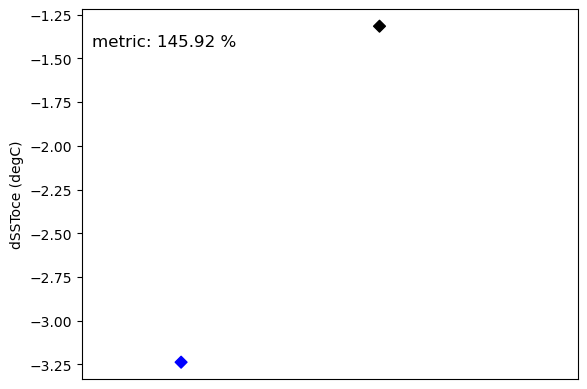

In [21]:
# scatter plot metric

metric_val = abs((ave-ave_obs)/ave_obs)*100

plt.scatter([0,1], [ave,ave_obs], c=['blue','black'], marker='D')

plt.xlim(-0.5,2)#range(-1,3,1)) #['model','obs']
plt.xticks([])

# print(obs_tos_prep["HadISST"].shape, obs_tauu_prep["ERA-Interim"].shape)
# plt.scatter(obs_tos_prep["HadISST"].data, obs_tauu_prep["ERA-Interim"].data,s=20, c='black', marker='D')

plt.ylabel(f'dSSToce (degC)')

## text slope
plt.text(0.02, 0.9, f'metric: {metric_val:.2f} %', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# print(metric_val)

# Diagnostic Level 2
The second level shows the evolution of dSST, dSSTnhf and dSSToce from June to December.

https://github.com/CLIVAR-PRP/ENSO_metrics/blob/d50c2613354564a155e0fe0f637eb448dfd7c479/lib/EnsoUvcdatToolsLib.py#L3682

```
     for ii in range(mm1, mm2):
         dSST[:, ii - mm1 + 1] = dSST[:, ii - mm1] + sstA[:, ii + 1] - sstA[:, ii]
         dSSTthf[:, ii - mm1 + 1] = dSSTthf[:, ii - mm1] + thfA[:, ii + 1] # cumsum, first month 0
```
dSSToce normalised SST change -> dt dt = MV2masked_where(abs(dt) < tmin, dt)
```
dSSTthf[:] = fraction * dSSTthf[:] / dt
    dSST[:] = dSST[:] / dt  # normalise 0 to 1 -> x-min/max-min (before cumulative?)
dSSToce = dSST - dSSTthf # then average across events (years)
```

In [19]:
## dSST
def dsst_lvl2(cube_prep):
    a_data = cube_prep.data.data
    a1_data = np.append(np.delete(a_data, 0), 0) #add 0 to end
    trend_data = a1_data - a_data #last month value invalid
    # cumulative, add diff to previous month, in each year?
    cube_prep.data = trend_data
    cube = extract_season(cube_prep,'JJASOND')

    tcoord = cube.coord('time')
    maxt, mint = tcoord.points.max(), tcoord.points.min()
    first, last = tcoord.units.num2date(mint).year, tcoord.units.num2date(maxt).year
    print(first, last)
    cube = extract_time(cube, start_year=first+1, end_year=last-1, 
                            start_month=1, start_day=1, end_month=12, end_day=31)
    arr = cube.data
    print(arr.min(), arr.max(), cube.shape) #normalise?
    arr_reshape = arr.reshape(int(cube.shape[0]/7), 7) # from June
    arr_reshape[:,0] = 0
    data_sum = np.cumsum(arr_reshape, axis=1).reshape(cube.shape[0])
    cube.data = data_sum
    cube = climate_statistics(cube, 'mean', period='month') #before cumulative? #lanina events 

    return cube

cb = model_ts_prep['ACCESS-ESM1-5']
dsst_cb = dsst_lvl2(cb)

obs_sst = dsst_lvl2(obs_ts_prep['TROPFLUX'])

# data_sum = np.cumsum(arr_reshape, axis=1).reshape(cb.shape[0])

1979 2014
-0.5169703960418701 0.40327761694788933 (238,)
1979 2018
-0.7692884355783463 0.5256602764129639 (266,)


In [20]:
## dSSTthf
def dthf_cumul(cube):
    cube = extract_season(cube,'JJASOND')
    tcoord = cube.coord('time')
    maxt, mint = tcoord.points.max(), tcoord.points.min()
    first, last = tcoord.units.num2date(mint).year, tcoord.units.num2date(maxt).year
    print(first, last)
    cube = extract_time(cube, start_year=first+1, end_year=last-1, 
                          start_month=1, start_day=1, end_month=12, end_day=31)
    arr = cube.data
    print(arr.min(), arr.max(), cube.shape) #normalise?
    arr_reshape = arr.reshape(int(cube.shape[0]/7), 7) # from June
    arr_reshape[:,0] = 0
    data_sum = np.cumsum(arr_reshape, axis=1).reshape(cube.shape[0])
    cube.data = data_sum
    cube = climate_statistics(cube, 'mean', period='month')
    return cube


def dSSTnhf_fraction(nhf): #update units?
    dtime = 60 * 60 * 24 * 30.42 #s month-1
    Cp = 4000 #J kg-1 degC-1
    rho = 1024 #kg m-3
    H = 50 #m
    dsstnhf = dtime * nhf / (Cp * rho * H)
    arr = dsstnhf.data
    print(arr.min(), arr.max(), cube.shape)
    return dsstnhf

1979 2014
-36.39019 22.518896 (238,)
1979 2018
-57.535023 39.691845 (266,)
-1.0713533 0.0 (472,)
units: <bound method BaseMetadata.name of <iris 'Cube' of sea_surface_temperature / (degC) (month_number: 7)>> degC, <bound method BaseMetadata.name of <iris 'Cube' of unknown / (kg.s-3) (month_number: 7)>> kg.s-3, <bound method BaseMetadata.name of <iris 'Cube' of sea_surface_temperature / (degC) (month_number: 7)>> degC
-0.3898888 0.0 (472,)
units: <bound method BaseMetadata.name of <iris 'Cube' of sea_surface_temperature / (degC) (month_number: 7)>> degC, <bound method BaseMetadata.name of <iris 'Cube' of unknown / (kg.s-3) (month_number: 7)>> kg.s-3, <bound method BaseMetadata.name of <iris 'Cube' of sea_surface_temperature / (degC) (month_number: 7)>> degC


Text(0.5, 1.0, 'ENSO SST change')

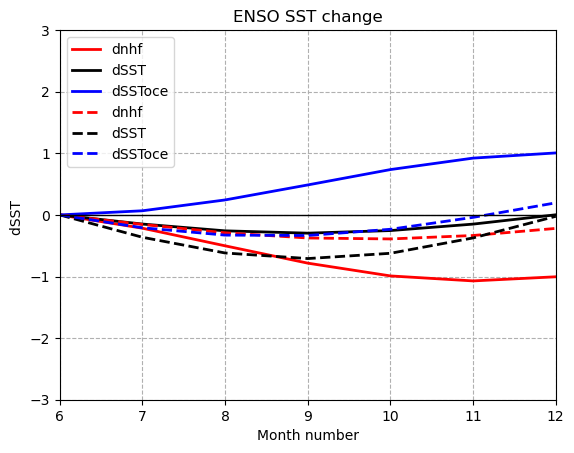

In [22]:
mod_nhf = dthf_cumul(model_nhf_prep['ACCESS-ESM1-5'])
obs_nhf = dthf_cumul(obs_nhf_prep['ERA-Interim'])

def plot_cubes_oce(nhf, dsst_cb, linestyle='solid'):
    dnhf = dSSTnhf_fraction(nhf)
    dSSToce = dsst_cb.copy()
    dSSToce.data = dsst_cb.data - dnhf.data #set name units
    
    qplt.plot(dnhf, label='dnhf', linestyle=linestyle, color='red', linewidth=2)
    print(f'units: {dsst_cb.name} {dsst_cb.units}, {dnhf.name} {dnhf.units}, {dSSToce.name} {dSSToce.units}')
    qplt.plot(dsst_cb, label='dSST', linestyle=linestyle, color='black', linewidth=2) #offset or update units
    qplt.plot(dSSToce, label='dSSToce',linestyle=linestyle, color='blue', linewidth=2)
    #return cubes

plot_cubes_oce(mod_nhf, dsst_cb)

plot_cubes_oce(obs_nhf, obs_sst, 'dashed')
plt.legend()
plt.xlim(6,12)
plt.ylabel('dSST ')
plt.ylim(-3,3)
plt.grid(linestyle='--')
plt.axhline(y=0, color='black', linewidth=1)
plt.title('ENSO SST change')

Figure 2: temporal evolution of evolution of sea surface temperature anomalies (SSTA), i.e. dSST, SSTA changes by total heat flux anomalies (NHFA), i.e. dSSTnhf and SSTA changes by anomalous ocean circulation, i.e. dSSToce in the eastern equatorial Pacific (Niño3 averaged) during all La Niña (multiplied by -1) and El Niño for 1°C of warming. Usually SSTA develop too early due to too much warming by dSSToce. The black, blue and red curves show respectively dSST, dSSTnhf and dSSToce, dashed and solid lines show respectively the reference and the model.

In [ ]:
events = enso_events(model_ts_enso['ACCESS-ESM1-5'])
print(events)
#run above without monthly statistics
mod_data = dSSTnhf_ninonina(events, model)

events = enso_events(obs_tos_enso['TROPFLUX'])
print(events)
obs_data = dSSTnhf_ninonina(events, obs)